# Documentation

**Author:** Spencer Ressel

**Created:** June 14th, 2023

---

This code numerically solves the governing equations from Matsuno (1966). It was initially written by Daniel Lloveras as a project for the course ATM S 582.  The solver uses the pseudospectral method with leapfrog time differencing to solve the equations of motion.

---

# Imports

In [25]:
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import time
import json
from glob import glob
import numpy as np
import xarray as xr
import scipy as sp
from scipy import special
from scipy.signal import hilbert
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gs
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Auxiliary Functions
import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple
from ipynb.fs.full.modified_colormap import Ahmed21_colormap
Ahmed_cmap = Ahmed21_colormap()
from ipynb.fs.full.tapering_functions import taper_meridionally, fringe_region_damping_function
from ipynb.fs.full.perlin_noise import generate_perlin_noise_2d
from ipynb.fs.full.normalize_data import normalize_data

sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/')
from ipynb.fs.full.numerical_solver_plotting_functions import plot_horizontal_structure, animate_horizontal_structure

print("Imports complete")

Imports complete


# Specify Physical Constants

In [2]:
simulation_moisture = True
moisture_advection = True
simulation_damping = True
moisture_coupling = True
simulation_diffusion = False
fringe_region = False
wavenumber_filtering = True
# moisture_sensitivity_structure = '-step-y'
# temperature_sensitivity_structure = '-step-y'
moisture_sensitivity_structure = ''
temperature_sensitivity_structure = ''
mean_moisture_profile = 'gaussian'

############################ Fundamental Constants #############################
GRAVITY = 9.81                           # g [m/s^2]
EQUIVALENT_DEPTH = 250.                  # H [m]
CORIOLIS_PARAMETER = 2.29e-11            # ß [m^-1 s^-1]
EARTH_RADIUS = 6371.0072e3               # R_e [m]
AIR_DENSITY = 1.225                      # ρ_a [kg m^-3]
WATER_DENSITY = 997                      # ρ_w [kg m^-3]
LATENT_HEAT = 2260000                    # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004                     # c_p [J kg^-1]

# Implement diffusion
DIFFUSIVITY = 0.2                      # D   [m^2 s^-1]
laplacian_u = 0
laplacian_v = 0
laplacian_T = 0
laplacian_q = 0

### Conversion factors ###
METERS_PER_DEGREE = 2*np.pi*EARTH_RADIUS/360
# METERS_PER_DEGREE = 55e3
SECONDS_PER_DAY = 86400
COLUMN_AVERAGE_MASS = 1000*100/9.81
##########################

#### Ahmed (2021) constants ####
GROSS_DRY_STABILITY = 3.12e4             # M_s [K kg m^-2]

MOISTURE_SENSITIVITY = (1/(6*3600) if simulation_moisture else 0)  # ε_q [s^-1]
# TEMPERATURE_SENSITIVITY = (0 if simulation_damping else 0)   # ε_t [s^-1]
TEMPERATURE_SENSITIVITY = (1/(2*3600) if simulation_damping else 0)   # ε_t [s^-1]
CLOUD_RADIATIVE_PARAMETER = (0.2 if simulation_damping else 0)   # r [-]

sigma_x_multiplier = (1 if simulation_moisture and moisture_advection else 0) # n_σ_x[-]
sigma_y_multiplier = (1 if simulation_moisture and moisture_advection else 0) # n_σ_y[-]

ZONAL_MOISTENING_PARAMETER = 5e-4*sigma_x_multiplier        # σ_x [K kg m^-3]
# MERIDIONAL_MOISTENING_PARAMETER = 9e-9*sigma_y_multiplier   # σ_y [K kg m^-4]
MERIDIONAL_MOISTENING_PARAMETER = 6.06e-9*sigma_y_multiplier   # σ_y [K kg m^-4]
MERIDIONAL_OFFSET_PARAMETER = 0*METERS_PER_DEGREE           # δ_y [m]
##############################################################################

################################ Derived quantities ##################################
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)         # c_g [m s^-1]
time_scale = (CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)   # T [s]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)  # L [m]
gross_moisture_stratification = 0.75*GROSS_DRY_STABILITY             # M_q [K kg m^-2]
effective_sensitivity = (
    MOISTURE_SENSITIVITY 
    + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)
)                                                                    # ε_a [s^-1]
effective_gross_moist_stability = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
)*(1+CLOUD_RADIATIVE_PARAMETER) - CLOUD_RADIATIVE_PARAMETER          # m_eff [-]
scaled_zonal_parameter = ZONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_x
scaled_meridional_parameter = MERIDIONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_y


print(f"{'Important Parameter Values':^60}")
print(f"{'':=^60}")
print(f"Dry Gravity Wave Phase Speed:     {gravity_wave_phase_speed:>10.2f} m/s")
print(f"Time Scale:                       {time_scale*24/SECONDS_PER_DAY:>10.2f} hours")
print(f"Length Scale:                     {length_scale/1e3:>10.2f} km")
print(f"")
print(f"Damping: {simulation_damping}")
print(f"- Temperature Sensitivity:        {3600*TEMPERATURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Cloud-Radiative Parameter:      {CLOUD_RADIATIVE_PARAMETER:>10.2f}")
print(f"")
print(f"Moisture: {simulation_damping}")
print(f"- Mean Profile:                   {mean_moisture_profile:>14}")
print(f"- Moisture Sensitivity:           {3600*MOISTURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Zonal Moistening Parameter:     {sigma_x_multiplier:>10.2f} x {ZONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"- Meridional Moistening Parameter:{sigma_y_multiplier:>10.2f} x {MERIDIONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"- Meridional Offset Parameter:    {MERIDIONAL_OFFSET_PARAMETER/1e3:>10.2f} km")

print(f"{'':=^60}")
######################################################################################

                 Important Parameter Values                 
Dry Gravity Wave Phase Speed:          49.52 m/s
Time Scale:                             8.25 hours
Length Scale:                        1470.57 km

Damping: True
- Temperature Sensitivity:              0.50 hr^-1
- Cloud-Radiative Parameter:            0.20

Moisture: True
- Mean Profile:                         gaussian
- Moisture Sensitivity:                 0.17 hr^-1
- Zonal Moistening Parameter:           1.00 x 5.0e-04
- Meridional Moistening Parameter:      1.00 x 6.1e-09
- Meridional Offset Parameter:          0.00 km


# Specify Simulation Parameters

In [14]:
########################### Define simiulaton grid ############################
#### Standard simulation
n_days                   = 360                                # number of days in simulation
n_chunks                 = 12                                 # number of chunks over which the time stepping will be split

#### Long simulation
# n_days                   = 360                                # number of days in simulation
# n_chunks                 = 12                                 # number of chunks over which the time stepping will be split
n_time_steps             = int(1.2*2**12)                    # number of time steps
# n_time_steps             = int(1.2*2**14)                    # number of time steps
# n_time_steps             = int(2**9)                    # number of time steps
# meridional_domain_length = 5000e3                            # length of half y domain in m
meridional_domain_length = 7000e3                            # length of half y domain in m
zonal_domain_length      = 2*np.pi*EARTH_RADIUS              # length of x domain in m

#### Standard simulation
nx = 257                                                     # number of steps +1 in the zonal grid
ny = 129                                                     # number of steps +1 in the meridional grid

#### High-res simulation
# nx = 513                                                     # number of steps +1 in the zonal grid
# ny = 257                                                     # number of steps +1 in the meridional grid
zonal_grid_spacing = zonal_domain_length/(nx-1)              # spacing between zonal grid points in m
meridional_grid_spacing = 2*meridional_domain_length/(ny-1)  # spacing between meridional grid points in m

simulation_length = n_days*SECONDS_PER_DAY                   # simulation length in seconds

# Define the temporal grid points
if n_chunks == 1:
    time_points = np.linspace(
        0, 
        simulation_length, 
        n_time_steps
    )                                                         # Array of simulation time points  
    
else:
    time_points = np.linspace(
        0,
        simulation_length,
        n_chunks*n_time_steps
    )

time_step = np.diff(time_points)[0]                           # Length of a time step in s

# Define the spatial grid points
zonal_gridpoints = np.arange(-(nx-1)/2, (nx-1)/2, 1)*zonal_grid_spacing
meridional_gridpoints = np.arange(-(ny-1)/2, (ny-1)/2, 1)*meridional_grid_spacing

# Redefine nx, ny, based on actual grid
nt = len(time_points)                            # number of time steps
ny = len(meridional_gridpoints)                  # number of zonal grid points
nx = len(zonal_gridpoints)                       # number of meridional grid points

zonal_step_size = np.diff(zonal_gridpoints)[0]
meridional_step_size = np.diff(meridional_gridpoints)[0]

# Define Fourier arrays 
zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

# Calculate CFL condition
CFL_x = gravity_wave_phase_speed*time_step/zonal_step_size
CFL_y = gravity_wave_phase_speed*time_step/meridional_step_size

# Create a fringe region
fringe_region_latitude = 30
fringe_region_width = 5
fringe_region_strength = 0.000

if fringe_region:
    fringe_region_strength = 0.003
    
fringe_region_damping = fringe_region_damping_function(
    meridional_gridpoints/METERS_PER_DEGREE,
    -fringe_region_latitude, 
    fringe_region_latitude, 
    fringe_region_width, 
    fringe_region_strength
)

print(f"{'Simulation Parameters':^48}")
print(f"{'':=^48}")
print(
    f"{'Lx =':4}" + 
    f"{zonal_domain_length/1e3:>6.0f}{' km':<6}" + 
    f"{'| Δx = ':>5}" + 
    f"{zonal_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| nx = ':<5}" + 
    f"{nx:>5.0f}"
)
print(
    f"{'Ly =':4}" + 
    f"{2*meridional_domain_length/1e3:>6.0f}" + 
    f"{' km':<6}{'| Δy = ':>5}" + 
    f"{meridional_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| ny = ':<4}" + 
    f"{ny:>5.0f}"
)
print(
    f"{'T  =':4}" + 
    f"{simulation_length/SECONDS_PER_DAY:>6.0f}" + 
    f"{' days':<6}{'| Δt = ':>5}" + 
    f"{time_step:>8.1f}" + 
    f"{' sec':<5}" + 
    f"{'| nt = ':<5}" + 
    f"{nt:>5.0f}"
)
print(f"{'':=^48}")

# print(f"")
print(f"Fringe Region: {fringe_region}")
print(f"- Fringe Region Latitude:         {fringe_region_latitude:>10.2f}°N/S")
print(f"- Fringe Region Width:            {fringe_region_width:>10.2f}°")
print(f"- Fringe Region Strength:         {fringe_region_strength:>11.3f}")
print(f"{'':=^48}")
# print(f"CFL_x = {CFL_x:0.3f}", end="")
# if (CFL_x < 1/(np.sqrt(2)*np.pi)):
#     print(", numerically stable ✔")
# else:d
#     print(", CFL > 1/(π√2), numerically unstable!!")

    
# print(f"CFL_y = {CFL_y:0.3f}", end="")
# if (CFL_y < 1/(np.sqrt(2)*np.pi)):
#     print(", numerically stable ✔")
    
# else:
#     print(", CFL > 1/(π√2), numerically unstable!!")

print(f"CFL = {CFL_x + CFL_y:0.3f}", end="")
if (CFL_x + CFL_y < 1):
    print(", numerically stable ✔")
    
else:
    print(" > 1, numerically unstable!!")
    
print(f"{'':=^48}")
###########################################################################################

##### Plotting Parameters ####
grid_scaling =  1e-6

# Specify quiver spacing
n_quiver_points = 10
zonal_quiver_plot_spacing = int((1/n_quiver_points/2)*zonal_domain_length/zonal_step_size)
meridional_quiver_plot_spacing  = int((1/n_quiver_points)*2*meridional_domain_length/meridional_step_size)

             Simulation Parameters              
Lx = 40030 km   | Δx =    156.4 km  | nx =   256
Ly = 14000 km   | Δy =    109.4 km  | ny =   128
T  =   360 days | Δt =    527.4 sec | nt = 58980
Fringe Region: False
- Fringe Region Latitude:              30.00°N/S
- Fringe Region Width:                  5.00°
- Fringe Region Strength:               0.000
CFL = 0.406, numerically stable ✔


## Document simulation parameters

In [15]:
if simulation_damping == True:
    damping_state = 'damped'
else:
    damping_state = 'free'

if simulation_moisture == True:
    moisture_state = 'moist'
else:
    moisture_state = 'dry'

if moisture_coupling == True:
    coupling_state = 'coupled'
else:
    coupling_state = 'uncoupled'

if simulation_diffusion == True:
    diffusion_state = 'diffusive'
else:
    diffusion_state = 'non-diffusive'

additional_notes = ''
# additional_notes = '_' + 'wavenumber-filtered'
# additional_notes = '_reflected-domain'
# additional_notes = f"_limited-advection_S={fringe_region_strength}"

#### Document simulation details ####
os.chdir("/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
simulation_name = (
    f"epst{temperature_sensitivity_structure}={3600*TEMPERATURE_SENSITIVITY:0.2f}"
  + f"_epsq{moisture_sensitivity_structure}={3600*MOISTURE_SENSITIVITY:0.2f}" 
  + f"_r={CLOUD_RADIATIVE_PARAMETER:0.1f}"
  + f"_nx={sigma_x_multiplier:0.1f}"
  + f"_ny={sigma_y_multiplier:0.2f}"
  + f"{additional_notes}"
  + (f"_{'fringe-region'}" if fringe_region else '')
  + (f"_{'wavenumber-filtered'}" if wavenumber_filtering else '')
  + (f"_{mean_moisture_profile}-mean-moisture" if simulation_moisture else '')
  + f"_{diffusion_state}-{damping_state}-{moisture_state}-{coupling_state}-simulation"
)

output_file_directory = f"output/WTG/{simulation_name}"
if not os.path.exists(output_file_directory):
    os.mkdir(output_file_directory)
    print(f"Output folder created")
    print(f"Simulation details: {simulation_name}")
else:
    print(f"Output folder already created")
    print(f"Simulation details: {simulation_name}")

if os.path.exists(f"{output_file_directory}/documentation.txt"):
    print("Old documentation exists, updating")
    os.system(f"rm {output_file_directory}/documentation.txt")

f = open(f"{output_file_directory}/documentation.txt", "w+")

f.write(f"Physical Constants {'':=^50}\n")
f.write(f"gravity                                  {GRAVITY:>10.3f} m/s^2 \n")
f.write(f"equivalent depth                         {EQUIVALENT_DEPTH:>10.3f} m \n")
f.write(f"dry gravity wave phase speed             {gravity_wave_phase_speed:>10.3f} m s^-1 \n")
f.write(f"coriolis parameter                       {CORIOLIS_PARAMETER*1e11:>10.3f} x 10^-11 m^-1 s^-1 \n")
f.write(f"earth radius                             {EARTH_RADIUS/1e3:>10.3f} km \n")
f.write(f"air density                              {AIR_DENSITY:>10.3f} kg m^-3 \n")
f.write(f"water density                            {WATER_DENSITY:>10.3f} kg m^-3 \n")
f.write(f"latent heat of vaporization              {LATENT_HEAT/1e3:>10.3f} KJ kg^-1 \n")
f.write(f"specific heat capacity                   {SPECIFIC_HEAT:>10.3f} J kg^-1 K^-1 \n")
f.write(f"\n")

f.write(f"Ahmed 2021 Constants {'':=^50}\n")
f.write(f"gross dry stability                      {GROSS_DRY_STABILITY/1e4:>10.3f} x 10^4 K kg m^-2 \n")
f.write(f"gross mositure stratification            {gross_moisture_stratification/1e4:>10.3f} x 10^4 K kg m^-2 \n")
f.write(f"convective sensitivity to moisture       {3600*MOISTURE_SENSITIVITY:>10.3f} hr^-1 \n")
f.write(f"convective sensitivity to temperature    {3600*TEMPERATURE_SENSITIVITY:>10.3f} hr^-1 \n")
f.write(f"cloud radiative feedback parameter       {CLOUD_RADIATIVE_PARAMETER:>10.3f} \n")
f.write(f"zonal moisture gradient parameter        {ZONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-3 \n")
f.write(f"meridional moisture gradient parameter   {MERIDIONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-4 \n")
f.write(f"\n")

f.write(f"Other Parameters {'':=^50}\n")
f.write(f"length scale                             {length_scale/1e3:>10.3f} km \n")
f.write(f"time scale                               {time_scale/3600:>10.3f} hr \n")
f.write(f"CFL condition in x                       {CFL_x:>10.3f} \n")
f.write(f"CFL condition in y                       {CFL_y:>10.3f} \n")
f.write(f"\n")

f.write(f"Simulation Parameters {'':=^50}\n")
f.write(f"simulation length                        {n_days:>10.3f} days \n")
f.write(f"time step length                         {time_step/3600:>10.3f} hr \n")
f.write(f"number of time steps                     {nt:>10.3f} \n")
f.write(f"zonal domain length                      {zonal_domain_length/1e3:>10.3f} km \n")
f.write(f"zonal step size                          {zonal_step_size/1e3:>10.3f} km \n")
f.write(f"number of zonal steps                    {nx:>10.3f} \n")
f.write(f"meridional domain length                 {2*meridional_domain_length/1e3:>10.3f} km \n")
f.write(f"meridional step size                     {meridional_step_size/1e3:>10.3f} km \n")
f.write(f"number of meridional steps               {ny:>10.3f} \n")
f.write(f"\n")

f.write(f"Simulation diffusion {'':=^50}\n")
f.write(f"diffusion - {simulation_diffusion} \n")
f.write(f"diffusivity coefficient                  {DIFFUSIVITY:>10.3f} \n")
f.write(f"\n")

f.write(f"Fringe Region Parameters {'':=^50}\n")
f.write(f"fringe region - {fringe_region} \n")
f.write(f"fringe region latitude                   {fringe_region_latitude:>10.3f}°N/S \n")
f.write(f"fringe region width                      {fringe_region_width:>10.3f}° \n")
f.write(f"fringe region strength                   {fringe_region_strength:>10.3f} \n")
f.write(f"{'':=^72}\n")

f.close()

print("Documentation created")

Output folder already created
Simulation details: epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation
Old documentation exists, updating
Documentation created


# Estimate Gaussian Mean Moisture profile

## Load ERA5 CWV data

In [16]:
TCWV_data = xr.load_dataset('/home/disk/eos7/sressel/research/data/ECMWF/ERA5/monthly_reanalysis_CWV_CIT_2002_2014.nc')
total_column_water_vapor = TCWV_data['tcwv'].sel(latitude=slice(30,-30))
era5_latitude = TCWV_data['latitude'].sel(latitude=slice(30,-30))
era5_longitude = TCWV_data['longitude']
era5_time = TCWV_data['time']

## Fit Gaussian to data

σ_y = 1.004e-08


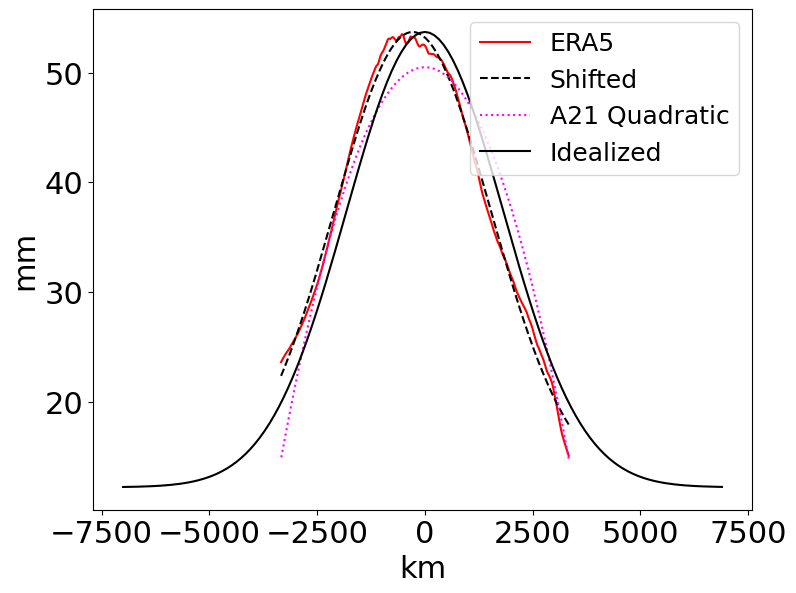

In [17]:
from scipy.optimize import curve_fit 

# Define the column integrated moisture profile <b>
column_integrated_moisture_profile = 54.6

# Define the product of the column integrated velocity and moisture profiles <Vb>
column_integrated_velocity_moisture_product = -19.4

# Calculate the time and zonal mean CWV from ERA5
era5_mean_moisture_profile = total_column_water_vapor.sel(longitude=slice(60,165)).mean(dim=['longitude', 'time']).values

# Define the Gaussian fitting profile
def Gauss(x, A, B, C, D): 
    y = A + B*np.exp(-1*((x-D)/C)**2) 
    return y 

# Solve for the best fit 
parameters, covariance = curve_fit(
    Gauss, 
    era5_latitude.values, 
    era5_mean_moisture_profile
) 

gaussian_vertical_offset = parameters[0]/column_integrated_moisture_profile

gaussian_magnitude = parameters[1]/column_integrated_moisture_profile

# The length scale of the Gaussian fit
gaussian_length_scale = parameters[2]*METERS_PER_DEGREE  

# The meridional offset of the CWV relative to the equator
gaussian_meridional_offset = parameters[3]*METERS_PER_DEGREE

# Calculate the fitted moisture profile
gaussian_mean_moisture_profile = Gauss(
    era5_latitude.values*METERS_PER_DEGREE, 
    gaussian_vertical_offset*column_integrated_moisture_profile,
    gaussian_magnitude*column_integrated_moisture_profile, 
    gaussian_length_scale, 
    gaussian_meridional_offset,
) 

def Quadratic(x, A, B):
    y = A - 0.5*B*x**2
    return y

quadratic_parameters, quadratic_covariance = curve_fit(
    Quadratic, 
    era5_latitude.values*METERS_PER_DEGREE, 
    era5_mean_moisture_profile
) 
quadratic_vertical_offset = quadratic_parameters[0]/column_integrated_moisture_profile
quadratic_width = quadratic_parameters[1]/column_integrated_moisture_profile

quadratic_mean_moisture_profile = Quadratic(
    era5_latitude.values*METERS_PER_DEGREE, 
    quadratic_vertical_offset*column_integrated_moisture_profile,
    quadratic_width*column_integrated_moisture_profile
)

if mean_moisture_profile == 'gaussian':
    MERIDIONAL_MOISTENING_PARAMETER = -column_integrated_velocity_moisture_product*2*gaussian_magnitude/(gaussian_length_scale**2)*LATENT_HEAT/SPECIFIC_HEAT
    print(f"σ_y = {MERIDIONAL_MOISTENING_PARAMETER:0.3e}")

# Plot the mean moisture profile and fitted profiles
plt.figure(figsize=(8.5,6.5))
plt.plot(era5_latitude*METERS_PER_DEGREE/1e3, era5_mean_moisture_profile, color='red', label='ERA5') 
plt.plot(era5_latitude*METERS_PER_DEGREE/1e3, gaussian_mean_moisture_profile, color='k', ls='--', label='Shifted') 
plt.plot(era5_latitude*METERS_PER_DEGREE/1e3, quadratic_mean_moisture_profile, color='magenta', ls=':', label='A21 Quadratic') 
plt.plot(meridional_gridpoints/1e3, 
         (
             column_integrated_moisture_profile*(gaussian_vertical_offset + gaussian_magnitude*np.exp(-(meridional_gridpoints/gaussian_length_scale)**2))
         ), color='k', label='Idealized')
plt.xlabel('km')
plt.ylabel('mm')
plt.legend(loc='best', fontsize=18)
plt.show()

# Initial Conditions

## Initial Condition Function

In [18]:
def generate_wavelike_initial_condition(
    initial_wave,
    n_wavelengths = 2,
    save_initial_condition=False,
    
):
    
    """
    This function generates data for the initial two time steps required to perform leap-frog numerical integration. 
    Options include wave type, number of wavelengths in the zonal domain, whether to include damping, moisture, and moisture 
    coupling in the simulation, and whether or not to save the output data to a netCDF file. 
    
    Keyword arguments:
    initial_wave (str)            : The wave type to be used in the initial condition. 
                                    Options are 'Kelvin', 'Rossby', 'EIG', or 'WIG'
    n_wavelengths (int)           : The number of wavelengths in the zonal direction (default 1) 
    simulation_damping (bool)     : Whether the simulation is free or damped (default False)
    simulation_moisture (bool)    : Whether the simulation is dry or includes moisture (default False)
    moisture_coupling (bool)      : Whether the moisture in the simulation feeds back to 
                                    affect the dry variables (default False)
    save_initial_condition (bool) : Whether or not the initial condition data is saved to a netCDF file (default False)
    
    """
    initial_wavenumber = 2*np.pi*n_wavelengths/zonal_domain_length
    initial_temperature_anomaly = 0.1*COLUMN_AVERAGE_MASS/1.6

    #### Initialize arrays
    zonal_velocity = np.zeros((2,ny,nx))
    meridional_velocity = np.zeros((2,ny,nx))
    column_temperature = np.zeros((2,ny,nx))
    column_moisture = np.zeros((2,ny,nx))

    # Generate data arrays 
    if initial_wave == 'Kelvin-wave':

        # u(x,y,t=0) = c × ψ(y/L, 1) × e^(ikx) [m s^-1]
        zonal_velocity[0] = gravity_wave_phase_speed*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

        # <T>(x,y,t=0)
        column_temperature[0] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

        if simulation_moisture == True:
            column_moisture[0] = -(
                gross_moisture_stratification/gravity_wave_phase_speed**2
            )*gravity_wave_phase_speed**2*np.real(
                np.einsum(
                    'i,j->ij',
                    mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
        zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])


    else:
        if initial_wave == 'Rossby-wave':
            initial_frequency = (
                CORIOLIS_PARAMETER*initial_wavenumber
                /(initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number+1))
            )

        elif initial_wave == 'EIG-wave':
            initial_frequency = -gravity_wave_phase_speed*np.sqrt(
                    initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
                )

        elif initial_wave == 'WIG-wave':
            initial_frequency = gravity_wave_phase_speed*np.sqrt(
                    initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
                )


        # v(x,y,t=0) = i(1/ß)(ω^2-(ck)^2) × ψ(y/L, m) × e^(ikx) [m s^-1]
        meridional_velocity[0] = np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        1j*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)*(1/CORIOLIS_PARAMETER)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
        zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # <T>(x,y,t=0) =  (M_s/c) x L × (0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [K kg m^-2]
        column_temperature[0] = (
            GROSS_DRY_STABILITY/gravity_wave_phase_speed
        )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        if simulation_moisture == True:
            column_moisture[0] = -(
                gross_moisture_stratification/gravity_wave_phase_speed
            )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                    np.einsum(
                        'i,j->ij',
                        (
                            0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                                *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                            - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                                *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                        ),
                        np.exp(1j*initial_wavenumber*zonal_gridpoints)
                    )
                )

        # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
        zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        meridional_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])

    if save_initial_condition == True:
        print("Attempting to save data...")
        initial_condition_data = xr.Dataset(
            data_vars = {
                'u' : (["it", "y", "x"], zonal_velocity[-2:]),
                'v' : (["it", "y", "x"], meridional_velocity[-2:]),
                'T' : (["it", "y", "x"], column_temperature[-2:]),
                'q' : (["it", "y", "x"], column_moisture[-2:])
            },
            coords = {
            "x" : zonal_gridpoints,
            "y" : meridional_gridpoints,
            "it": np.array([0,1])
            }
        )
        
        print(
            f"Data to be saved as:\n{output_file_directory}/{initial_wave}_initial-condition/"
              + f"{initial_condition_name}_intial-condition-data.nc"
        )
        
        # Check if the data already exists
        if os.path.exists(
            f"{output_file_directory}/{initial_wave}_initial-condition/"
            + f"{initial_condition_name}_intial-condition-data.nc"
        ):
            
            # Prompt the user to overwrite the existing data
            # overwrite_data = input("Data already exists. Overwrite? [y/n]")
            overwrite_data = 'y'
            if overwrite_data == 'y':
                os.system(
                    f"rm {output_file_directory}/{initial_wave}_initial-condition/"
                    + f"{initial_condition_name}_intial-condition-data.nc"
                )
                print("Data overwritten")
                initial_condition_data.to_netcdf(
                    f"{output_file_directory}/{initial_wave}_initial-condition/"
                    + f"{initial_condition_name}_intial-condition-data.nc"
                )
                print("Initial condition data saved as netCDF")
            else:
                print("Original data retained")
        else:
            initial_condition_data.to_netcdf(
                f"{output_file_directory}/{initial_wave}_initial-condition/"
                + f"{initial_condition_name}_intial-condition-data.nc"
            )
            print("Initial condition data saved as netCDF")
    
    return zonal_velocity, meridional_velocity, column_temperature, column_moisture

## Specify initial conditions

Output directory:
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation
Initial condition: k=2.0_m=1_Rossby-wave
Creating subfolder for initial condition...

Attempting to save data...
Data to be saved as:
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation/Rossby-wave_initial-condition/k=2.0_m=1_Rossby-wave_intial-condition-data.nc
Initial condition data saved as netCDF
Plotting note - values are scaled! Maximum moisture anomaly set to 0.60 mm 

Plot saved as:
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation/Rossby-wave_initial-condition/k=2.0_m=1_Rossby-wave_initial-condition_horizontal_structure_20240110-1113.png


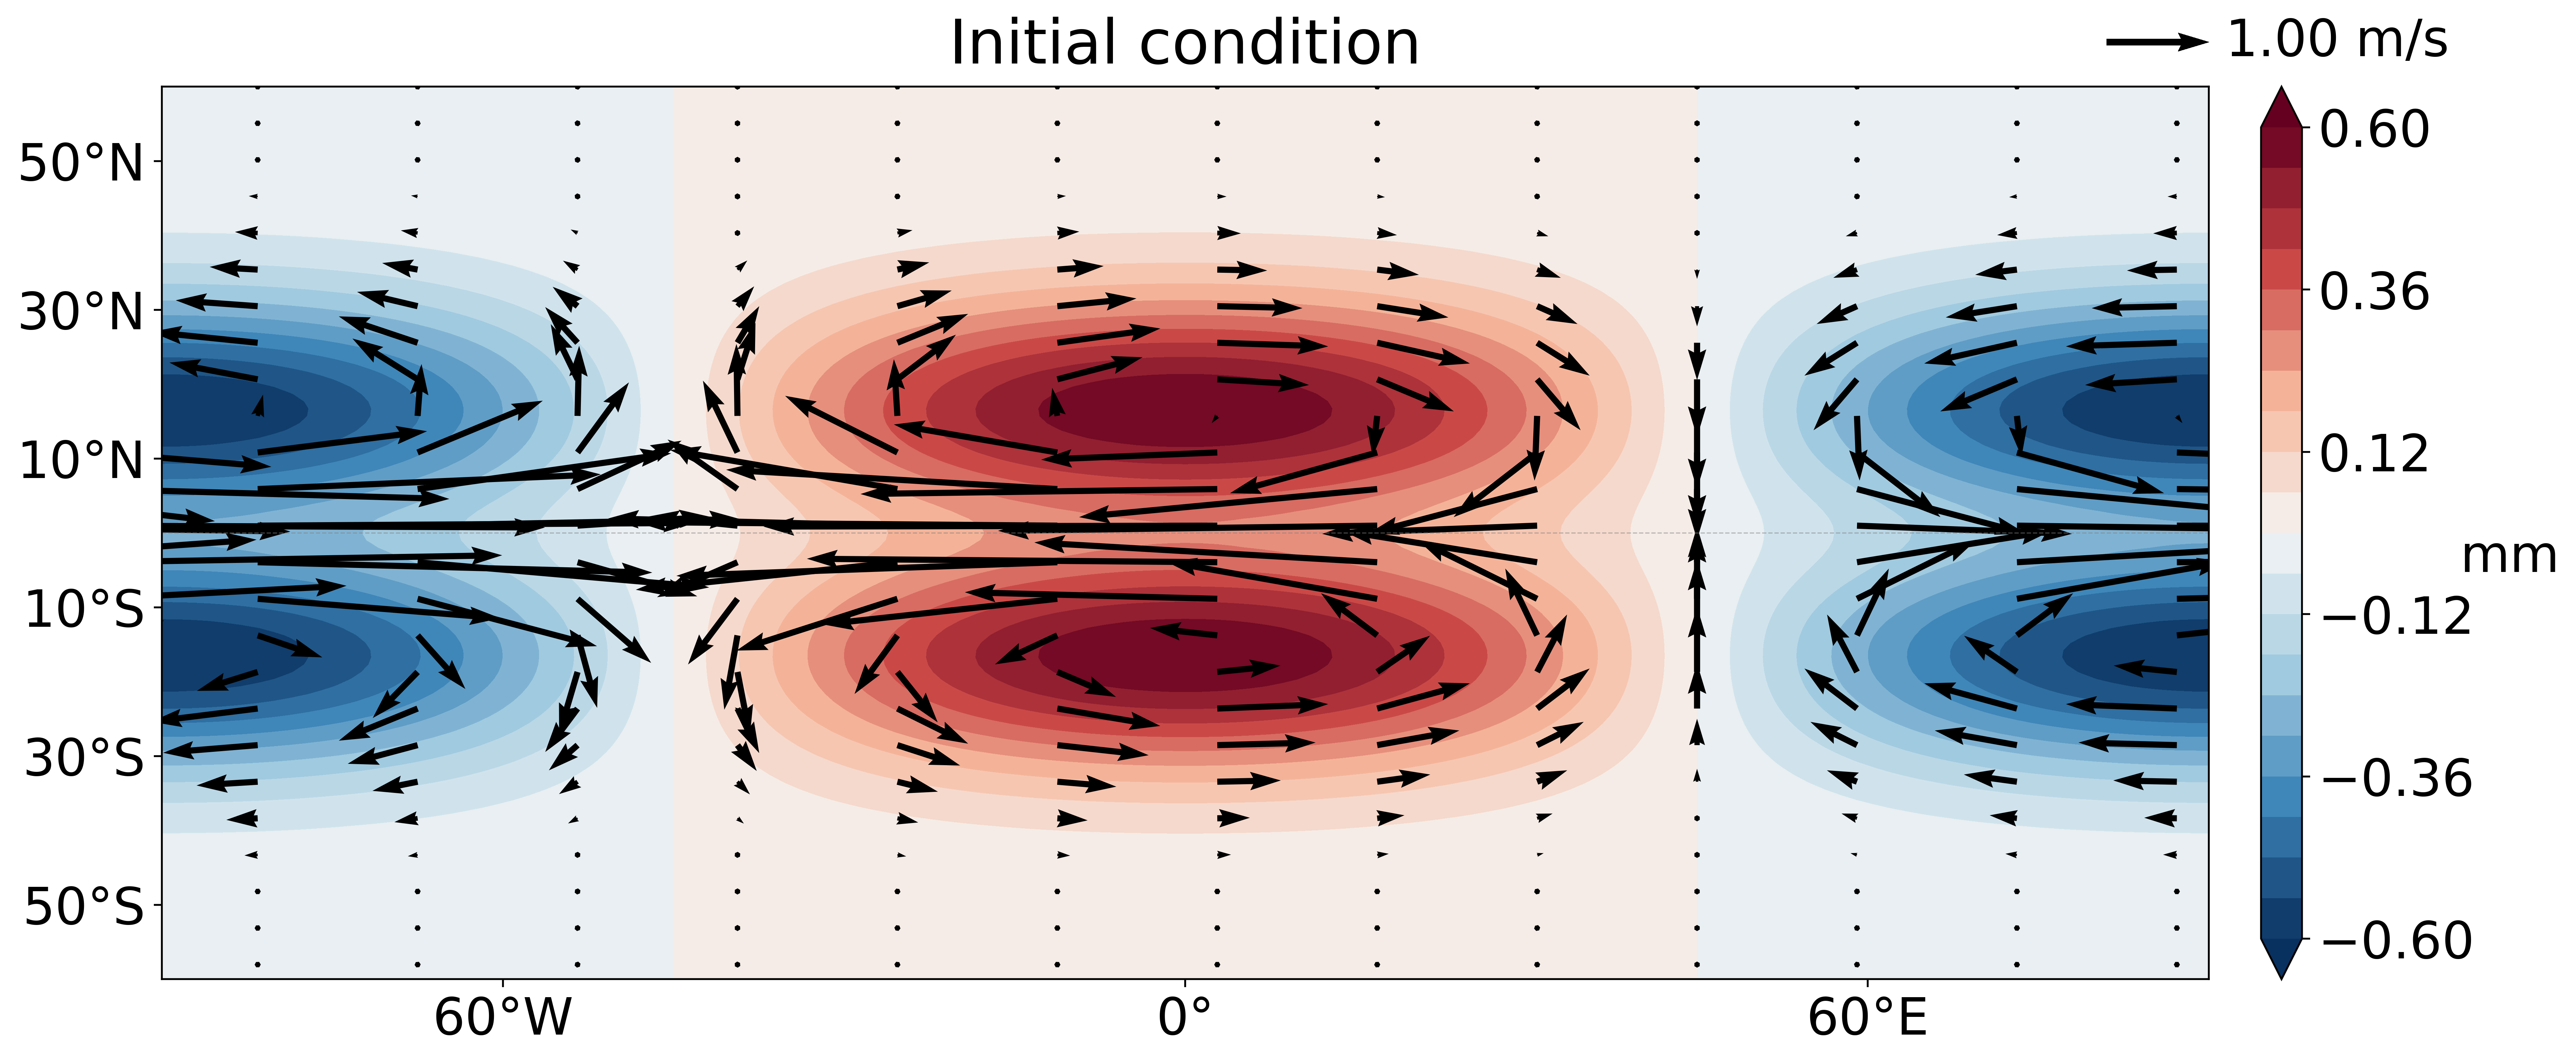

In [24]:
# Specify the type of wave for the initial condition
# initial_condition_type = 'rolled-moisture-blob'
initial_condition_type = 'Rossby-wave'
n_wavelengths = 2
mode_number = 1

initial_condition_name = f"k={n_wavelengths:0.1f}_m={mode_number}_{initial_condition_type}"
# initial_condition_name = f"k=1-5_m={mode_number}_{initial_condition_type}
# initial_condition_name = f"random-perturbations"
# initial_condition_name = f"moisture-blob"

print(f"Output directory:\n{output_file_directory}")
print(f"Initial condition: {initial_condition_name}")
if not os.path.exists(f"{output_file_directory}/{initial_condition_type}_initial-condition/"):
    os.system(f"mkdir {output_file_directory}/{initial_condition_type}_initial-condition/")
    print(f"Creating subfolder for initial condition...")
else:
    print(f"Subfolder already exists for initial condition")
print(f"==============================================\n")

#### Generate new initial condition
[
    generated_zonal_velocity,
    generated_meridional_velocity,
    generated_column_temperature,
    generated_column_moisture
] = generate_wavelike_initial_condition(initial_condition_type, n_wavelengths = n_wavelengths, save_initial_condition=True)

##### Specify which initial condition to use when solving
# Generated
initial_zonal_velocity = generated_zonal_velocity
initial_meridional_velocity = generated_meridional_velocity
initial_column_temperature = np.zeros_like(generated_column_temperature)
initial_column_moisture = generated_column_moisture

# grand_max = np.max(
#     (
#         np.abs(initial_zonal_velocity[0]),
#         np.abs(initial_meridional_velocity[0]),
#         np.abs(initial_column_temperature[0]),
#         np.abs(initial_column_moisture[0])
#     )
# )

# initial_zonal_velocity /= grand_max
# initial_meridional_velocity /= grand_max
# initial_column_temperature /= grand_max
# initial_column_moisture /= grand_max
# initial_column_moisture = np.zeros_like(initial_column_temperature)

# half_field = generate_perlin_noise_2d((ny, nx//2), (16,16))
# full_field = np.concatenate((half_field, half_field[:, ::-1]), axis=1)

# initial_zonal_velocity = np.zeros((2, ny, nx))# 
# initial_meridional_velocity = np.zeros((2, ny, nx))# 
# initial_column_temperature = np.zeros((2, ny, nx))
# initial_column_moisture = np.zeros((2, ny, nx))
# initial_column_moisture[0] = np.einsum(
#     'i, j -> ji',
#     np.exp(-(zonal_gridpoints/(n_wavelengths*EARTH_RADIUS))**2),
#     # np.roll(np.exp(-(2*np.pi*n_wavelengths*zonal_gridpoints/zonal_domain_length)**2), -80),
#     # np.exp(-(meridional_gridpoints/length_scale)**2),
#    mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1),
# )
    

physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    # (-180, 179), 
    (-180/n_wavelengths, 180/n_wavelengths), 
    (-60, 60),
    # 10,10,
    20//n_wavelengths, 10//n_wavelengths,  
    True, 
    'converted',
    0.6,
    # 'natural',
    # 1,
    grid_scaling
)

# Plot the initial conditon below
plot_horizontal_structure(
    0,
    zonal_gridpoints,
    meridional_gridpoints,
    time_points,
    zonal_velocity = initial_zonal_velocity, 
    meridional_velocity = initial_meridional_velocity, 
    column_temperature = initial_column_temperature, 
    column_moisture = initial_column_moisture, 
    specified_output_file_directory=output_file_directory,
    specified_initial_condition_name=initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region, fringe_region_latitude, fringe_region_width),
    plotting_parameters = plotting_parameters
)

# Run Simulation

## Runge-Kutta Timestepping

In [10]:
n_rk_steps = 3
save_downsampled = True
# overwrite_data = input("Overwrite existing data? [y/n]: ")
overwrite_data = 'y'

moisture_sensitivity_array = MOISTURE_SENSITIVITY * (
    (
        np.exp(-(meridional_gridpoints/length_scale)**2)[:, None]
        if moisture_sensitivity_structure == '-exp-y' else 1
    )
    *(
    (1-fringe_region_damping_function(meridional_gridpoints/METERS_PER_DEGREE, -30, 30, 25, 1))[:, None]
        if  moisture_sensitivity_structure == '-step-y' else 1
    )
)

for chunk in range(1, n_chunks+1):
    chunk_length = nt//n_chunks
    # chunk_length = nt
    
    # Initialize the variables to simulate
    zonal_velocity = np.zeros((chunk_length, ny, nx))
    meridional_velocity = np.zeros((chunk_length, ny, nx))
    column_moisture = np.zeros((chunk_length, ny, nx))
    
    print(f"Chunk {chunk}/{n_chunks}")
    
    # The first chunk is initialized with preset initial conditions
    if chunk == 1:
        zonal_velocity[0] = initial_zonal_velocity[0]
        meridional_velocity[0] = initial_meridional_velocity[0]
        column_moisture[0] = initial_column_moisture[0]
     
    # Subsequent chunks are initialized with the output of the previous chunk
    elif chunk > 1:
        final_timesteps_model_data_input = xr.load_dataset(
            f"{output_file_directory}/{initial_condition_type}_initial-condition/"
            + f"{initial_condition_name}_final-timesteps-model-data_chunk-{chunk-1}of{n_chunks}.nc"
        )

        zonal_velocity[0] = final_timesteps_model_data_input['u'].to_numpy()
        meridional_velocity[0] = final_timesteps_model_data_input['v'].to_numpy()
        column_moisture[0] = final_timesteps_model_data_input['q'].to_numpy()

    ### Step forward using Runge-Kutta time-differencing
    for it in tqdm(range(1, chunk_length), position=0, leave=True, ncols=100):
        zonal_velocity_rk       = np.zeros((n_rk_steps+1, ny, nx))
        meridional_velocity_rk  = np.zeros((n_rk_steps+1, ny, nx))
        column_moisture_rk      = np.zeros((n_rk_steps+1, ny, nx))

        zonal_velocity_rk[0]       = zonal_velocity[it-1]
        meridional_velocity_rk[0]  = meridional_velocity[it-1]
        column_moisture_rk[0]      = column_moisture[it-1]
        
        for rk_step in range(1, n_rk_steps+1):
            
            ### Transform to spectral space
            # zonal fft
            ux_fft = np.fft.fft(zonal_velocity_rk[rk_step-1], axis=1)
            vx_fft = np.fft.fft(meridional_velocity_rk[rk_step-1], axis=1)    
            qx_fft = np.fft.fft(column_moisture_rk[rk_step-1], axis=1)

            # ### Compute first derivatives
            # zonal derivatives
            dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
            dvdx_fft = 1j*zonal_wavenumber[None,:]*vx_fft    
            dqdx_fft = 1j*zonal_wavenumber[None,:]*qx_fft

            # # # meridional fft
            # uy_fft = np.fft.fft(zonal_velocity_rk[rk_step-1], axis=0)
            # vy_fft = np.fft.fft(meridional_velocity_rk[rk_step-1], axis=0)    
            # qy_fft = np.fft.fft(column_moisture_rk[rk_step-1], axis=0)
            
            # dudy_fft = 1j*meridional_wavenumber[:,None]*uy_fft
            # dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft    
            # dqdy_fft = 1j*meridional_wavenumber[:,None]*qy_fft

            if simulation_diffusion:
                # ### Compute second derivatives
                # # zonal derivatives
                dudx_dx_fft = (1j*zonal_wavenumber[None,:])*dudx_fft
                dvdx_dx_fft = (1j*zonal_wavenumber[None,:])*dvdx_fft        
                dqdx_dx_fft = (1j*zonal_wavenumber[None,:])*dqdx_fft

                # meridional derivatives
                dudy_dy_fft = (1j*meridional_wavenumber[:,None])*dudy_fft
                dvdy_dy_fft = (1j*meridional_wavenumber[:,None])*dvdy_fft        
                dqdy_dy_fft = (1j*meridional_wavenumber[:,None])*dqdy_fft
    
            #### Transform back to physical space
            # zonal
            dudx = np.real(ifft(dudx_fft, axis=1))
            dvdx = np.real(ifft(dvdx_fft, axis=1))    

            # meridional
            # dudy = np.real(ifft(dudy_fft, axis=0))
            # dvdy = np.real(ifft(dvdy_fft, axis=0))    
            
            if simulation_diffusion:
                # zonal
                dudx_dx = np.real(ifft(dudx_dx_fft, axis=1))
                dvdx_dx = np.real(ifft(dvdx_dx_fft, axis=1))        
                dqdx_dx = np.real(ifft(dqdx_dx_fft, axis=1))

                # meridional
                dudy_dy = np.real(ifft(dudy_dy_fft, axis=0))
                dvdy_dy = np.real(ifft(dvdy_dy_fft, axis=0))        
                dqdy_dy = np.real(ifft(dqdy_dy_fft, axis=0))

                # Calculate the laplacian for each variable (∇^2)
                laplacian_u = dudx_dx + dudy_dy
                laplacian_v = dvdx_dx + dvdy_dy        
                laplacian_q = dqdx_dx + dqdy_dy

            #### Compute y-derivatives in reflected space
            # zonal velocity
            zonal_velocity_rk_reflected = np.concatenate(
                (
                    zonal_velocity_rk[rk_step-1],
                    -zonal_velocity_rk[rk_step-1, ::-1, :]
                ),
                axis=0
            )

            # meridional velocity
            meridional_velocity_rk_reflected = np.concatenate(
                (
                    meridional_velocity_rk[rk_step-1],
                    meridional_velocity_rk[rk_step-1, ::-1, :],
                ),
                axis=0
            )

            # Compute the wavenumbers of the new domain
            meridional_wavenumber_reflected = 2*np.pi*np.fft.fftfreq(2*ny, meridional_step_size)

            uy_fft = np.fft.fft(zonal_velocity_rk_reflected, axis=0)
            vy_fft = np.fft.fft(meridional_velocity_rk_reflected, axis=0)
            
            # meridional derivatives
            dudy_fft = 1j*meridional_wavenumber_reflected[:,None]*uy_fft
            dvdy_fft = 1j*meridional_wavenumber_reflected[:,None]*vy_fft

            # meridional
            dudy = np.real(ifft(dudy_fft, axis=0))[:ny]
            dvdy = np.real(ifft(dvdy_fft, axis=0))[:ny]
            
            #### Zonal Velocity
            zonal_velocity_forcing = (
                # Core forcings
                + CORIOLIS_PARAMETER * meridional_gridpoints[:, None] * meridional_velocity_rk[rk_step-1] 
                # Conditional forcings
                - (fringe_region_damping[:, None] * zonal_velocity_rk[rk_step-1] if fringe_region else 0)
                + (DIFFUSIVITY * laplacian_u if simulation_diffusion else 0)
            )

            zonal_velocity_rk[rk_step] = zonal_velocity[it-1] + (time_step/(n_rk_steps - rk_step + 1))*zonal_velocity_forcing

            #### Meridional Velocity
            meridional_velocity_forcing = (
                # Core forcings
                - CORIOLIS_PARAMETER * meridional_gridpoints[:,None] * zonal_velocity_rk[rk_step-1] 
                # Conditional forcings
                - (fringe_region_damping[:, None] * meridional_velocity_rk[rk_step-1] if fringe_region else 0)
                + (DIFFUSIVITY * laplacian_v if simulation_diffusion else 0)
            )

            meridional_velocity_rk[rk_step] = (
                meridional_velocity[it-1] + (time_step/(n_rk_steps - rk_step + 1))*meridional_velocity_forcing
            )
  
            #### Column Moisture
            if simulation_moisture == True:
                column_moisture_forcing = (
                    + ZONAL_MOISTENING_PARAMETER * zonal_velocity_rk[rk_step-1]
                    - ( 
                        MERIDIONAL_MOISTENING_PARAMETER
                        * ( # Quadratic base state σ_y * y * v_1
                            meridional_gridpoints[:,None]
                            if mean_moisture_profile == 'quadratic' else 1
                        )
                        * ( # Exponential base state σ_y * y * e^(-y^2) * v_1
                            (meridional_gridpoints*np.exp(-(meridional_gridpoints/gaussian_length_scale)**2))[:,None]
                            if mean_moisture_profile == 'gaussian' else 1
                        )
                        * meridional_velocity_rk[rk_step-1]
                      )
                    # - MERIDIONAL_MOISTENING_PARAMETER * meridional_gridpoints[:, None] * meridional_velocity_rk[rk_step-1]
                    # - (
                    #     MERIDIONAL_MOISTENING_PARAMETER
                    #     * (1-fringe_region_damping_function(-30, 30, 5, 1))[:, None]
                    #     * MERIDIONAL_OFFSET_PARAMETER
                    #     * meridional_velocity_rk[rk_step-1]
                    #   )
                    + gross_moisture_stratification * (dudx+dvdy)
                    - moisture_sensitivity_array    * column_moisture_rk[rk_step-1]
                    # Conditional forcings
                    - (fringe_region_damping[:, None] * column_moisture_rk[rk_step-1] if fringe_region else 0)
                    + (DIFFUSIVITY * laplacian_q if simulation_diffusion else 0)
                )
    
                column_moisture_rk[rk_step] = (
                    column_moisture[it-1] + (time_step/(n_rk_steps - rk_step + 1))*column_moisture_forcing
                )

            # #### Meridional Boundary conditions
            meridional_velocity_rk[rk_step, 0] = 0.
            meridional_velocity_rk[rk_step, -1] = 0.

            zonal_velocity_rk[rk_step, 0] = 0.
            zonal_velocity_rk[rk_step, -1] = 0.
            
            column_moisture_rk[rk_step, 0] = 0.
            column_moisture_rk[rk_step, -1] = 0.
            
        # The full time step is the result of the RK-time stepping
        zonal_velocity[it] = zonal_velocity_rk[-1]
        meridional_velocity[it] = meridional_velocity_rk[-1]
        column_moisture[it] = column_moisture_rk[-1]

        # Meridional boundary conditions
        meridional_velocity[it,0] = 0.
        meridional_velocity[it,-1] = 0.

        zonal_velocity[it,0] = 0.
        zonal_velocity[it,-1] = 0.
        
        column_moisture[it,0] = 0.
        column_moisture[it,-1] = 0.
        
        if wavenumber_filtering:
            zonal_velocity_fft = fft(zonal_velocity[it], axis=1)
            meridional_velocity_fft = fft(meridional_velocity[it], axis=1)
            column_moisture_fft = fft(column_moisture[it], axis=1)
        
            zonal_velocity_fft_masked = np.copy(zonal_velocity_fft)
            meridional_velocity_fft_masked = np.copy(meridional_velocity_fft)
            column_moisture_fft_masked = np.copy(column_moisture_fft)
    
            zonal_velocity_fft_masked[:, np.where(np.abs(zonal_wavenumber) != zonal_wavenumber[n_wavelengths])] = 0. + 0.*1j
            meridional_velocity_fft_masked[:, np.where(np.abs(zonal_wavenumber) != zonal_wavenumber[n_wavelengths])] = 0. + 0.*1j
            column_moisture_fft_masked[:, np.where(np.abs(zonal_wavenumber) != zonal_wavenumber[n_wavelengths])] = 0. + 0.*1j
            
            zonal_velocity[it] = np.real(ifft(zonal_velocity_fft_masked, axis=1))
            meridional_velocity[it] = np.real(ifft(meridional_velocity_fft_masked, axis=1))
            column_moisture[it] = np.real(ifft(column_moisture_fft_masked, axis=1))
        
    if save_downsampled:       
        
        downsample_interval = round_to_multiple(np.floor(6*3600/time_step), n_chunks)
        full_indices = np.array(
            [i * downsample_interval for i in range(len(time_points[::downsample_interval]))]
        )
        chunked_indices = full_indices % (chunk_length-1)
        full_data_indices = np.split(chunked_indices, np.where(np.diff(chunked_indices) < 0)[0] + 1)
        data_indices = full_data_indices[chunk-1]
        
        full_time_indices = np.split(full_indices, np.where(np.diff(chunked_indices) < 0)[0] + 1)
        time_indices = full_time_indices[chunk-1]

        if not os.path.exists(f"{output_file_directory}/{initial_condition_type}_initial-condition/"):
            print(f"Creating subfolder for {initial_condition_type} initial condition...")
            os.system(f"mkdir {output_file_directory}/{initial_condition_type}_initial-condition/")
            
        print("Downsampled data")
        # Store model variables in an xarray Dataset
        downsampled_model_data = xr.Dataset(
            data_vars = {
                'u' : (["time", "y", "x"], zonal_velocity[:-1,:,:][data_indices]),
                'v' : (["time", "y", "x"], meridional_velocity[:-1,:,:][data_indices]),
                'T' : (["time", "y", "x"], np.zeros_like(column_moisture)[:-1,:,:][data_indices]),
                'q' : (["time", "y", "x"], column_moisture[:-1,:,:][data_indices]),
            },
            coords = {
            "x" : zonal_gridpoints,
            "y" : meridional_gridpoints,
            "time" : time_points[time_indices]
            }
        )

        print(f"---- Saving data...")
        # Save the Dataset to a netCDF file
        downsampled_model_data.to_netcdf(
            f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
            + f"{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
        )
        print(f"---- Data saved \n")

    # if chunk == 1:
    #     first_chunk_full_data = xr.Dataset(
    #         data_vars = {
    #             'u' : (["time", "y", "x"], zonal_velocity),
    #             'v' : (["time", "y", "x"], meridional_velocity),
    #             'T' : (["time", "y", "x"], column_temperature),
    #             'q' : (["time", "y", "x"], column_moisture),
    #         },
    #         coords = {
    #         "x" : zonal_gridpoints,
    #         "y" : meridional_gridpoints,
    #         "time" : time_points[:chunk_length]
    #         }
    #     )
        
    #     print(f"---- Saving first chunk data...")
    #     # Save the Dataset to a netCDF file
    #     first_chunk_full_data.to_netcdf(
    #         f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
    #         + f"{initial_condition_name}_first-chunk_full-data.nc"
    #     )
    #     print(f"---- Data saved \n")
    
    # Store the final time step of model variables in an xarray Dataset
    # if not os.path.exists(
    #     f"{output_file_directory}/{initial_condition_name}"
    #     + f"_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
    # ):

    print("Final timestep data")
    print("---- Saving data...")
    final_timesteps_model_data = xr.Dataset(
        data_vars = {
            'u' : (["y", "x"], zonal_velocity[-1]),
            'v' : (["y", "x"], meridional_velocity[-1]),
            'T' : (["y", "x"], np.zeros_like(column_moisture)[-1]),
            'q' : (["y", "x"], column_moisture[-1])
        },
        coords = {
        "x" : zonal_gridpoints,
        "y" : meridional_gridpoints,
        }
    )

    # else:
    #     print("---- Data already exists")
    #     if overwrite_data == 'y':
    #         print("------ Overwriting existing data...")
    #         final_timesteps_model_data = xr.load_dataset(
    #             f"{output_file_directory}/{initial_condition_name}" 
    #             + f"_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
    #         )

    #         final_timesteps_model_data['u'][:] = zonal_velocity[-1]
    #         final_timesteps_model_data['v'][:] = meridional_velocity[-1]
    #         final_timesteps_model_data['T'][:] = column_temperature[-1]
    #         final_timesteps_model_data['q'][:] = column_moisture[-1]
            
    #     else:
    #         print("------ Existing data not overwritten")
            
    final_timesteps_model_data.to_netcdf(
        f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
        + f"{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
    )
    print(f"---- Data saved \n")

print("===================")
print("Simulation complete")

Chunk 1/1


100%|███████████████████████████████████████████████████████████| 4914/4914 [02:32<00:00, 32.27it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Simulation complete


# Compile downsampled data

In [11]:
data_to_compile = []
print(f"{output_file_directory}/{initial_condition_type}_initial-condition/")
print(f"==============================================================")
for chunk in range(1, n_chunks+1):
    data_to_compile.append(
        xr.load_dataset(
            f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
            + f"{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
        )
    )
    print(f"{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc")
print(f"==============================================================")
if os.path.exists(
    f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{initial_condition_name}_downsampled-model-data_compiled.nc"
):
    print(f"Overwriting existing data... \n")
else:
    print(f"Compiling data... \n")

compiled_data = xr.concat(data_to_compile, dim='time')
compiled_data.to_netcdf(
            f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
            + f"{initial_condition_name}_downsampled-model-data_compiled.nc"
        )

print(
    f"Data compiled as:\n"
    + f"{output_file_directory}/{initial_condition_type}_initial-condition/" 
    + f"{initial_condition_name}_downsampled-model-data_compiled.nc"
)

output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation/Kelvin-wave_initial-condition/
k=2.0_m=1_Kelvin-wave_downsampled-model-data_chunk-1of1.nc
Overwriting existing data... 

Data compiled as:
output/WTG/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_wavenumber-filtered_gaussian-mean-moisture_non-diffusive-damped-moist-coupled-simulation/Kelvin-wave_initial-condition/k=2.0_m=1_Kelvin-wave_downsampled-model-data_compiled.nc


# Export experiment variables

In [12]:
# Get all local variables in the current namespace
experiment_variables = dict(
    simulation_moisture = simulation_moisture,
    moisture_advection = moisture_advection,
    simulation_damping = simulation_damping,
    moisture_coupling = moisture_coupling,
    simulation_diffusion = simulation_diffusion,
    fringe_region = fringe_region,
    moisture_sensitivity_structure = moisture_sensitivity_structure,
    temperature_sensitivity_structure = temperature_sensitivity_structure,
    mean_moisture_profile = mean_moisture_profile,
    moisture_length_scale = gaussian_length_scale,
    GRAVITY = GRAVITY,
    EQUIVALENT_DEPTH = EQUIVALENT_DEPTH,
    CORIOLIS_PARAMETER = CORIOLIS_PARAMETER,
    EARTH_RADIUS = EARTH_RADIUS,
    AIR_DENSITY = AIR_DENSITY,
    WATER_DENSITY = WATER_DENSITY,
    LATENT_HEAT = LATENT_HEAT,
    SPECIFIC_HEAT = SPECIFIC_HEAT,
    DIFFUSIVITY = DIFFUSIVITY,
    # laplacian_u = laplacian_u,
    # laplacian_v = laplacian_v,
    # laplacian_T = laplacian_T,
    # laplacian_q = laplacian_q,
    METERS_PER_DEGREE = METERS_PER_DEGREE,
    SECONDS_PER_DAY = SECONDS_PER_DAY,
    COLUMN_AVERAGE_MASS = COLUMN_AVERAGE_MASS,
    GROSS_DRY_STABILITY = GROSS_DRY_STABILITY,
    MOISTURE_SENSITIVITY = MOISTURE_SENSITIVITY,
    TEMPERATURE_SENSITIVITY = TEMPERATURE_SENSITIVITY,
    CLOUD_RADIATIVE_PARAMETER = CLOUD_RADIATIVE_PARAMETER,
    sigma_x_multiplier = sigma_x_multiplier,
    sigma_y_multiplier = sigma_y_multiplier,
    ZONAL_MOISTENING_PARAMETER = ZONAL_MOISTENING_PARAMETER,
    MERIDIONAL_MOISTENING_PARAMETER = MERIDIONAL_MOISTENING_PARAMETER,
    MERIDIONAL_OFFSET_PARAMETER = MERIDIONAL_OFFSET_PARAMETER,
    gravity_wave_phase_speed = gravity_wave_phase_speed,
    time_scale = time_scale,
    length_scale = length_scale,
    gross_moisture_stratification = gross_moisture_stratification,
    effective_sensitivity = effective_sensitivity,
    effective_gross_moist_stability = effective_gross_moist_stability,
    scaled_zonal_parameter = scaled_zonal_parameter,
    scaled_meridional_parameter = scaled_meridional_parameter,
    n_days = n_days,
    n_chunks = n_chunks,
    n_time_steps = n_time_steps,
    meridional_domain_length = meridional_domain_length,
    zonal_domain_length = zonal_domain_length,
    nt = nt,    
    nx = nx,
    ny = ny,
    zonal_grid_spacing = zonal_grid_spacing,
    meridional_grid_spacing = meridional_grid_spacing,
    simulation_length = simulation_length,
    time_step = time_step,
    zonal_step_size = zonal_step_size,
    meridional_step_size = meridional_step_size,
    CFL_x = CFL_x,
    CFL_y = CFL_y,
    fringe_region_latitude = fringe_region_latitude,
    fringe_region_width = fringe_region_width,
    fringe_region_strength = fringe_region_strength,
    grid_scaling = grid_scaling,
    additional_notes = additional_notes,
    simulation_name = simulation_name,
    output_file_directory = output_file_directory,
    n_rk_steps = n_rk_steps,
    save_downsampled = save_downsampled,
    save_time = time.strftime('%Y%m%d-%H%M'),
)

# Save to a JSON file

print(f"Saving experiment variables as JSON")
print(f"===================================")
with open(
    f"{output_file_directory}/experiment_variables.json", 'w') as json_file:
    
        if os.path.exists(f"{output_file_directory}/experiment_variables.json"):
            print(f"JSON already exists, overwriting...")
        else:
            print(f"Creating JSON...")
        json.dump(experiment_variables, json_file)
    
print(f"===================================")
print("Experiment variables saved")

Saving experiment variables as JSON
JSON already exists, overwriting...
Experiment variables saved


# Auxiliary functions

In [ ]:
# damp_lat = 30
# damp_width = 10
# damp_strength = 1
# t_index = 0
# fringe_region_damping = fringe_region_damping_function(-damp_lat, damp_lat, damp_width, damp_strength)

# plt.style.use('bmh')
# plt.figure(figsize=(16,4))
# plt.plot(
#     meridional_gridpoints/METERS_PER_DEGREE, 
#     output_zonal_velocity[t_index, :, 15]
# )
# plt.plot(
#     meridional_gridpoints/METERS_PER_DEGREE, 
#     fringe_region_damping,
#     ls='--', color='k', lw=1
# )

# plt.plot(
#     meridional_gridpoints/METERS_PER_DEGREE, 
#     fringe_region_damping*output_zonal_velocity[t_index, :, 15],
#     color=bmh_colors('red')
# )
# plt.plot(
#     meridional_gridpoints/METERS_PER_DEGREE, 
#     (1-fringe_region_damping)*output_zonal_velocity[t_index, :, 15], 
#     color=bmh_colors('green')
# )

# plt.axvline(x=damp_lat, color='k', ls=':')
# plt.axvline(x=-damp_lat, color='k', ls=':')

# plt.axvline(x=damp_lat-damp_width, color='k', ls=':')
# plt.axvline(x=-damp_lat+damp_width, color='k', ls=':')

# plt.show()

## Zonally varying σ_x function

In [ ]:
def zonally_varying_sigma_x_function(
    western_edge=-30, 
    eastern_edge=30, 
    half_width=15
):
    
    sigma_x = np.zeros_like((zonal_gridpoints))
    width = 2*half_width*METERS_PER_DEGREE/EARTH_RADIUS
    non_dimensional_zonal_coordinate = zonal_gridpoints/EARTH_RADIUS
    
    west_region_indices = np.where((zonal_gridpoints/METERS_PER_DEGREE <= western_edge))[0]
    central_region_indices = np.where(
        (zonal_gridpoints/METERS_PER_DEGREE > western_edge)*(zonal_gridpoints/METERS_PER_DEGREE < eastern_edge)
    )[0]
    east_region_indices = np.where((zonal_gridpoints/METERS_PER_DEGREE >= eastern_edge))[0]
    
    sigma_x[west_region_indices] = np.exp(
        -(non_dimensional_zonal_coordinate[west_region_indices]-western_edge*METERS_PER_DEGREE/EARTH_RADIUS)**2/width**2
    )
    sigma_x[central_region_indices] = 1
    sigma_x[east_region_indices] = np.exp(
        -(non_dimensional_zonal_coordinate[east_region_indices]-eastern_edge*METERS_PER_DEGREE/EARTH_RADIUS)**2/width**2
    )
    sigma_x[sigma_x < 1e-6] = 0

    if np.min(sigma_x) > 0:
        raise ValueError('Half-width too large')

    return sigma_x

# Old Leapfrog Timestepping

In [ ]:
# save_downsampled = True
# overwrite_data = input("Overwrite existing data? [y/n]")

# for chunk in range(1, n_chunks+1):
#     chunk_length = nt//n_chunks
#     # chunk_length = nt
    
#     # Initialize the variables to simulate
#     zonal_velocity = np.zeros((chunk_length, ny, nx))
#     meridional_velocity = np.zeros((chunk_length, ny, nx))
#     column_temperature = np.zeros((chunk_length, ny, nx))
#     column_moisture = np.zeros((chunk_length, ny, nx))
    
#     print(f"Chunk {chunk}/{n_chunks}")
    
#     # The first chunk is initialized with preset initial conditions
#     if chunk == 1:
#         zonal_velocity[0] = initial_zonal_velocity[0]
#         meridional_velocity[0] = initial_meridional_velocity[0]
#         column_temperature[0] = initial_column_temperature[0]
#         column_moisture[0] = initial_column_moisture[0]
        
#         zonal_velocity[1] = initial_zonal_velocity[1]
#         meridional_velocity[1] = initial_meridional_velocity[1]
#         column_temperature[1] = initial_column_temperature[1]
#         column_moisture[1] = initial_column_moisture[1]
        
#     # Subsequent chunks are initialized with the output of the previous chunk
#     elif chunk > 1:
#         final_timesteps_model_data_input = xr.open_dataset(
#             f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk-1}of{n_chunks}.nc"
#         )

#         zonal_velocity[0] = final_timesteps_model_data_input['u'].sel(it=0).to_numpy()
#         meridional_velocity[0] = final_timesteps_model_data_input['v'].sel(it=0).to_numpy()
#         column_temperature[0] = final_timesteps_model_data_input['T'].sel(it=0).to_numpy()
#         column_moisture[0] = final_timesteps_model_data_input['q'].sel(it=0).to_numpy()
        
#         zonal_velocity[1] = final_timesteps_model_data_input['u'].sel(it=1).to_numpy()
#         meridional_velocity[1] = final_timesteps_model_data_input['v'].sel(it=1).to_numpy()
#         column_temperature[1] = final_timesteps_model_data_input['T'].sel(it=1).to_numpy()
#         column_moisture[1] = final_timesteps_model_data_input['q'].sel(it=1).to_numpy()
    
#     ### Step forward using leapfrong time-differencing
#     for it in tqdm(range(2,chunk_length), position=0, leave=True, ncols=100):
#         ### Transform to spectral space
#         ux_fft = fft(zonal_velocity[it-1],axis=1)
#         vy_fft = fft(meridional_velocity[it-1],axis=0)
#         Tx_fft = fft(column_temperature[it-1],axis=1)
#         Ty_fft = fft(column_temperature[it-1],axis=0)

#         ### Compute derivatives
#         dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
#         dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
#         dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
#         dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

#         ### Transform back to physical space
#         dudx = np.real(ifft(dudx_fft, axis=1))
#         dvdy = np.real(ifft(dvdy_fft, axis=0))
#         dTdx = np.real(ifft(dTdx_fft, axis=1))
#         dTdy = np.real(ifft(dTdy_fft, axis=0))

#         ### Step forward with leapfrog scheme
#         zonal_velocity[it] = (zonal_velocity[it-2] - 2*time_step*(
#             - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
#             + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx)
#         )

#         meridional_velocity[it] = (meridional_velocity[it-2] - 2*time_step*(
#             + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[it-1] 
#             + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy)
#         )

#         if moisture_coupling == True:
#             column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
#                 column_temperature[it-2] 
#                 - 2*time_step*(
#                     + GROSS_DRY_STABILITY*(dudx + dvdy)
#                     - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[it-1]
#                 )
#             )

#         elif moisture_coupling == False:
#             column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
#                 column_temperature[it-2] 
#                 - 2*time_step*(
#                     + GROSS_DRY_STABILITY*(dudx + dvdy)

#                 )
#             )

#         if simulation_moisture == True:
#             column_moisture[it] = (1/(1+2*MOISTURE_SENSITIVITY*time_step))*(
#                 column_moisture[it-2] 
#                 - 2*time_step*(
#                     - ZONAL_MOISTENING_PARAMETER*zonal_velocity[it-1]
#                     + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
#                     - gross_moisture_stratification*(dudx + dvdy)
#                     - TEMPERATURE_SENSITIVITY*column_temperature[it-1]
#                 )
#             )

#         ### Meridional boundary condition
#         meridional_velocity[it,0] = 0.
#         meridional_velocity[it,-1] = 0.
        
        
        
#         # zonal_velocity[it,0] = 0.
#         # zonal_velocity[it,-1] = 0.
        
#         # column_temperature[it,0] = 0.
#         # column_temperature[it,-1] = 0.
        
#         # column_moisture[it,0] = 0.
#         # column_moisture[it,-1] = 0.
    
#     if save_downsampled:       
        
#         downsample_interval = round_to_multiple(np.floor(12*3600/time_step), n_chunks)
#         full_indices = np.array([i * downsample_interval for i in range(len(time_points[::downsample_interval]))])
#         chunked_indices = full_indices % (chunk_length-2)
#         data_indices = chunked_indices[
#             (chunk-1)*(int(len(chunked_indices)/n_chunks)+1):chunk*(int(len(chunked_indices)/n_chunks)+1)
#         ]
#         time_indices = full_indices[
#             (chunk-1)*(int(len(chunked_indices)/n_chunks)+1):chunk*(int(len(chunked_indices)/n_chunks)+1)
#         ]
        
        
#         # Store model variables in an xarray Dataset
#         downsampled_model_data = xr.Dataset(
#             data_vars = {
#                 'u' : (["time", "y", "x"], zonal_velocity[:-2,:,:][data_indices]),
#                 'v' : (["time", "y", "x"], meridional_velocity[:-2,:,:][data_indices]),
#                 'T' : (["time", "y", "x"], column_temperature[:-2,:,:][data_indices]),
#                 'q' : (["time", "y", "x"], column_moisture[:-2,:,:][data_indices])
#             },
#             coords = {
#             "x" : zonal_gridpoints,
#             "y" : meridional_gridpoints,
#             "time" : time_points[time_indices]
#             }
#         )
        
        
#         if os.path.exists(f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"):
#             if overwrite_data == 'y':
#                 os.system(f"rm {output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc")
#                 print("Data overwritten")
#                 downsampled_model_data.to_netcdf(
#                     f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
#                 )
#                 print("Downsampled data saved as netCDF")
            
#         else:
#             # Save the Dataset to a netCDF file
#             downsampled_model_data.to_netcdf(
#                 f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
#             )

#             print(f"Chunk {chunk} downsampled data saved")

#     # Store the final two time steps of model variables in an xarray Dataset
#     final_timesteps_model_data = xr.Dataset(
#         data_vars = {
#             'u' : (["it", "y", "x"], zonal_velocity[-2:]),
#             'v' : (["it", "y", "x"], meridional_velocity[-2:]),
#             'T' : (["it", "y", "x"], column_temperature[-2:]),
#             'q' : (["it", "y", "x"], column_moisture[-2:])
#         },
#         coords = {
#         "x" : zonal_gridpoints,
#         "y" : meridional_gridpoints,
#         "it": np.array([0,1])
#         }
#     )
    
#     if os.path.exists(f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"):
#         if overwrite_data == 'y':
#             os.system(f"rm {output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc")
#             print("Data overwritten")
#             final_timesteps_model_data.to_netcdf(
#                 f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
#             )
#             print("Final timestep data saved as netCDF")
#     else:
#         # Save the Dataset to a netCDF file
#         final_timesteps_model_data.to_netcdf(
#             f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
#         )

# print("done")

#### Initial condition function

    # ########################### Initialize leapfrog method with one step forward ###########################
    # ### Transform to wavenumber space
    # ux_fft = fft(zonal_velocity[0],axis=1)
    # vy_fft = fft(meridional_velocity[0],axis=0)
    # Tx_fft = fft(column_temperature[0],axis=1)
    # Ty_fft = fft(column_temperature[0],axis=0)

    # ### Compute derivatives
    # dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    # dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    # dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
    # dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

    # ### Transform back to physical space
    # dudx = np.real(ifft(dudx_fft,axis=1))
    # dvdy = np.real(ifft(dvdy_fft,axis=0))
    # dTdx = np.real(ifft(dTdx_fft,axis=1))
    # dTdy = np.real(ifft(dTdy_fft,axis=0))

    # ### Step forward one time step
    # # u[1] = u[0] - Δt × (-ßyv[0] + (c^2/M_s)d<T>[0]/dx)
    # zonal_velocity[1] = zonal_velocity[0] - time_step*(
    #     - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
    #     + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx
    # )

    # # v[1] = v[0] - Δt × (ßyu[0] + (c^2/M_s)d<T>[0]/dy)
    # meridional_velocity[1] = meridional_velocity[0] - time_step*(
    #     + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[0] 
    #     + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy
    # )

    # # <T>[1] = <T>[0] - Δt × (M_s(du[0]/dx + dv[0]/dy) + ε_t(1+r)<T>[0] - ε_q(1+r)<q>)
    # if moisture_coupling == True:
    #     column_temperature[1] = column_temperature[0] - time_step*(
    #         + GROSS_DRY_STABILITY*(dudx + dvdy) 
    #         + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
    #         - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[0]
    #     )

    # elif moisture_coupling == False:
    #     column_temperature[1] = column_temperature[0] - time_step*(
    #         + GROSS_DRY_STABILITY*(dudx + dvdy) 
    #         + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
    #     )

    # if simulation_moisture == True:
    #     # <q>[1] = <q>[0] - Δt × (-σ_x×u[0] + σ_y×y×v[0] - M_q(du[0]/dx + dv[0]/dy) - ε_t<T>[0] + ε_q<q>[0])
    #     column_moisture[1] = column_moisture[0] - time_step*(
    #         - ZONAL_MOISTENING_PARAMETER*zonal_velocity[0]
    #         + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
    #         - gross_moisture_stratification*(dudx + dvdy) 
    #         - TEMPERATURE_SENSITIVITY*column_temperature[0]
    #         + MOISTURE_SENSITIVITY*column_moisture[0]   
    #     )

    ### Meridional boundary condition
    # meridional_velocity[1,0] = 0.
    # meridional_velocity[1,-1] = 0.
    
    # zonal_velocity[0,0] = 0.
    # zonal_velocity[0,-1] = 0

    # column_temperature[0,0] = 0.
    # column_temperature[0,-1] = 0

    # column_moisture[0,0] = 0.
    # column_moisture[0,-1] = 0